In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 5356.71it/s]


(422, 16) (422, 16)


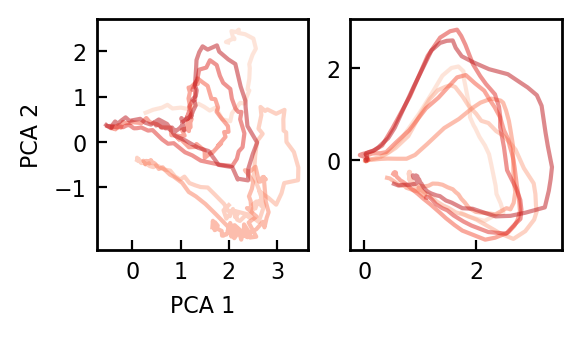

In [40]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model
from morphogenesis.plot_utils import plot_scalar, plot_tensor
from morphogenesis.dataset import *

transform = Reshape2DField()
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, 
                           drop_time=True, tmin=-15, tmax=45)
sqh_model = get_decomposition_model(sqh_dataset, model_name='SVDPipeline_PMGCrop')

vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, 
                            drop_time=True, tmin=-15, tmax=45)
vel_model = get_decomposition_model(vel_dataset, model_name='SVDPipeline_NoCrop')

from scipy.interpolate import splprep, splev
from morphogenesis.decomposition.decomposition_utils import get_decomposition_results

plt.rcParams['axes.linewidth'] = 1

fig, ax = plt.subplots(1, 2, figsize=(3, 1.5), dpi=200)

df = sqh_dataset.df.copy()
colors = plt.cm.Reds(np.linspace(0.2, 0.8, len(df.embryoID.unique())))

X = []
y0 = []

for i, embryoID in enumerate(df.embryoID.unique()):
    sqh = sqh_model.transform(sqh_dataset.values[embryoID])
    vel = vel_model.transform(vel_dataset.values[embryoID])

    ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i], alpha=0.5)
    ax[1].plot(vel[:,0], vel[:,1], c=colors[i], alpha=0.5)

    X.append(sqh)
    y0.append(vel)

X = np.concatenate(X)
y0 = np.concatenate(y0)
print(X.shape, y0.shape)

ax[0].set(xticks=[0, 1, 2, 3], yticks=[-1, 0, 1, 2], xlabel='PCA 1', ylabel='PCA 2');

(316, 16) (316, 16)


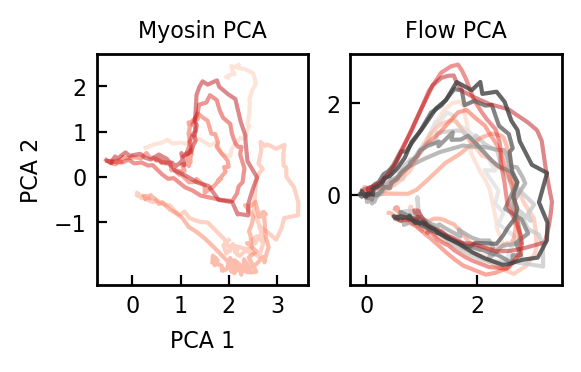

In [46]:
from sklearn.model_selection import train_test_split
X_train, _, y0_train, _ = train_test_split(X, y0, test_size=0.25, random_state=0)

print(X_train.shape, y0_train.shape)

from sklearn.kernel_ridge import KernelRidge

keep=4
model = KernelRidge(kernel='polynomial', alpha=2.0).fit(X_train[:, :keep], y0_train[:, :keep])

import pickle
with open('FlowKernelRidge.pkl', 'wb') as f:
    pickle.dump(model, f)

fig, ax = plt.subplots(1, 2, figsize=(3, 1.5), dpi=200)

colors = plt.cm.Reds(np.linspace(0.2, 0.8, len(df.embryoID.unique())))
c1 = plt.cm.Greys(np.linspace(0.2, 0.8, len(df.embryoID.unique())))

for i, embryoID in enumerate(df.embryoID.unique()):
    sqh = sqh_model.transform(sqh_dataset.values[embryoID])
    vel = vel_model.transform(vel_dataset.values[embryoID])

    vel1 = model.predict(sqh[:, :keep])

    ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i], alpha=0.5)
    ax[1].plot(vel[:,0], vel[:,1], c=colors[i], alpha=0.5)
    ax[1].plot(vel1[:, 0], vel1[:, 1], c=c1[i], alpha=0.8)

ax[0].set_title('Myosin PCA')
ax[1].set_title('Flow PCA')
ax[0].set(xticks=[0, 1, 2, 3], yticks=[-1, 0, 1, 2], xlabel='PCA 1', ylabel='PCA 2');
